This notebook consists of code for reading in the .tiff whole slide image files. It makes use of the openslide library and uses parts of the notebook from the [MIDOG challenge data exploration notebook](https://imig.science/midog/download-dataset/). 

The object detection model contained here is from the [Tensorflow Model Garden](https://github.com/tensorflow/models) and uses parts of a notebook for inferencing using this model. 

In [44]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import json
import cv2
from PIL import Image as im
import PIL.ImageDraw as ImageDraw
from pathlib import Path

In [5]:
!apt-get install python3-openslide
from openslide import open_slide

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-openslide is already the newest version (1.1.1-2ubuntu4).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [6]:
from google.colab import drive
drive.mount('/drive')

folder = "MyDrive/MIDOG_Challenge_2022"
midog_folder = Path("/drive") / Path(folder)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [7]:
image_folder = midog_folder / "images"

midog_ids = list(range(1, 151))
clc_ids = list(range(151,195))
cly_ids = list(range(195,250))
ccmct_ids = list(range(250,300))
net_ids = list(range(300,355))
mel_ids = list(range(355,406))

all_ids = {'human breast cancer': midog_ids,
           'canine lung cancer': clc_ids,
           'canine lymphoma' : cly_ids,
           'canine cutaneous mast cell tumor' : ccmct_ids,
           'human neuroendocrine tumor' : net_ids,
           'human melanoma' : mel_ids}

id_to_tumortype = {id:list(k for k in all_ids if id in all_ids[k])[0] for id in range(1,406)}

In [14]:
annotation_file = midog_folder / "MIDOG2022_training.json"
rows = []
with open(annotation_file) as f:
    data = json.load(f)

    #categories = {cat["id"]: cat["name"] for cat in data["categories"]}
    categories = {1: 'mitotic figure', 2: 'hard negative'}

    for row in data["images"]:
        file_name = row["file_name"]
        image_id = row["id"]
        width = row["width"]
        height = row["height"]

        tumortype = id_to_tumortype[image_id]
         
        for annotation in [anno for anno in data['annotations'] if anno["image_id"] == image_id]:
            box = annotation["bbox"]
            cat = categories[annotation["category_id"]]

            rows.append([file_name, image_id, width, height, box, cat, tumortype])

df = pd.DataFrame(rows, columns=["file_name", "image_id", "width", "height", "box", "cat", "tumortype"])
df

,file_name,image_id,width,height,box,cat,tumortype
0,001.tiff,1,7215,5412,"[4336, 346, 4386, 396]",hard negative,human breast cancer
1,001.tiff,1,7215,5412,"[756, 872, 806, 922]",hard negative,human breast cancer
2,001.tiff,1,7215,5412,"[270, 4044, 320, 4094]",hard negative,human breast cancer
3,001.tiff,1,7215,5412,"[6672.5, 706.5, 6722.5, 756.5]",hard negative,human breast cancer
4,002.tiff,2,7215,5412,"[1872, 319, 1922, 369]",hard negative,human breast cancer
...,...,...,...,...,...,...,...
20547,354.tiff,354,7215,5412,"[4601.5, 2435, 4651.5, 2485]",hard negative,human neuroendocrine tumor
20548,354.tiff,354,7215,5412,"[1839.5, 912.5, 1889.5, 962.5]",hard negative,human neuroendocrine tumor
20549,354.tiff,354,7215,5412,"[2759, 3247, 2809, 3297]",hard negative,human neuroendocrine tumor
20550,354.tiff,354,7215,5412,"[4713, 1373.5, 4763, 1423.5]",hard negative,human neuroendocrine tumor


In [17]:
current_file = df[df["file_name"] == "001.tiff"]

100 100 150 150


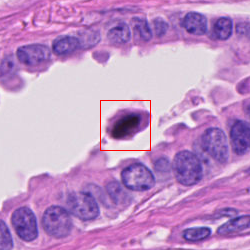

100 100 150 150


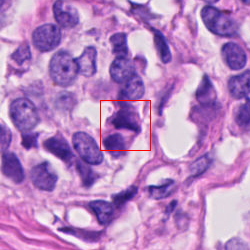

100 100 150 150


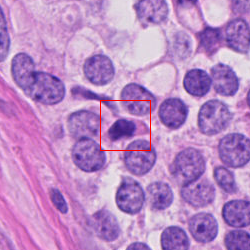

100.5 100.5 150.5 150.5


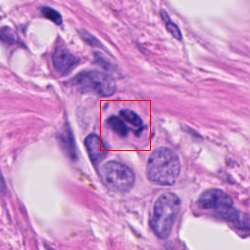

In [58]:
file_path = image_folder / "001.tiff"
slide = open_slide(str(file_path))
imgs = []
for id, anno in current_file.iterrows():
  left, bottom, right, top = anno.box
  centre_x, centre_y = int(left + ((right - left) / 2)), int(bottom + ((top - bottom) / 2)) 
  img = slide.read_region((centre_x - 125, centre_y - 125), level=0, size=(250, 250))

  left_edge, bottom_edge = centre_x - 125, centre_y - 125
  bbox_left = abs(left_edge - left)
  bbox_bottom = abs(bottom_edge - bottom)
  bbox_right = abs(left_edge - right)
  bbox_top = abs(bottom_edge - top)

  d = ImageDraw.Draw(img)
  d.rectangle([bbox_left, bbox_bottom, bbox_right, bbox_top], outline="red")

  display(img)



In [ ]:
base_model = keras.applications.resnet50.ResNet50(weights="imagenet",
                                                  include_top=False)
base_model.summary()
# avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
# class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
# loc_output = keras.layers.Dense(4)(avg)
# model = keras.models.Model(inputs=base_model.input,
#                            outputs=[class_output, loc_output])
# model.compile(loss=["sparse_categorical_crossentropy", "mse"],
#               loss_weights=[0.8, 0.2], # depends on what you care most about
#               optimizer=optimizer, metrics=["accuracy"])

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                          

In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3578, done.
remote: Counting objects: 100% (3578/3578), done.
remote: Compressing objects: 100% (2979/2979), done.
remote: Total 3578 (delta 942), reused 1511 (delta 545), pack-reused 0
Receiving objects: 100% (3578/3578), 47.07 MiB | 2.59 MiB/s, done.
Resolving deltas: 100% (942/942), done.


In [2]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1696518 sha256=d113b6bac27a50c576b8e3be7582bde2c3ebd4600727a6c37a958af2a5c556e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-f1_w2cnn/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=7622f912045431ba50f0ae6dc67bc3e1ee0f571727aedc51893c8ff0b4a99e88
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for avro-python3: filename=avro_python3-1.10.2-py3-none-any.whl size=44009 sha256=e502a738cb1ed7d3eddcf7704cd81ecc355b3c2ff58417d07ee1742c511de097
  Stored in directory: /root/.cache/pip/wheels/d6/e5/b1/6b151d9b535ee50aaa6ab27d145a0104b6df02e5636f0376da
  Created wheel for docopt: filename=docopt-

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [3]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [4]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def get_keypoint_tuples(eval_config):
  """Return a tuple list of keypoint edges from the eval config.
  
  Args:
    eval_config: an eval config containing the keypoint edges
  
  Returns:
    a list of edge tuples, each in the format (start, end)
  """
  tuple_list = []
  kp_list = eval_config.keypoint_edge
  for edge in kp_list:
    tuple_list.append((edge.start, edge.end))
  return tuple_list

In [ ]:
MODELS = {'centernet_with_keypoints': 'centernet_hg104_512x512_kpts_coco17_tpu-32', 'centernet_without_keypoints': 'centernet_hg104_512x512_coco17_tpu-8'}

model_display_name = 'centernet_with_keypoints'
model_name = MODELS[model_display_name]

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

if model_display_name == 'centernet_with_keypoints':
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
  !tar -xf centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
  !mv centernet_hg104_512x512_kpts_coco17_tpu-32/checkpoint models/research/object_detection/test_data/
else:
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_coco17_tpu-8.tar.gz
  !tar -xf centernet_hg104_512x512_coco17_tpu-8.tar.gz
  !mv centernet_hg104_512x512_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

In [ ]:
pipeline_config = os.path.join('models/research/object_detection/configs/tf2/',
                                model_name + '.config')
model_dir = 'models/research/object_detection/test_data/checkpoint/'

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [ ]:
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [ ]:
image_dir = 'models/research/object_detection/test_images/'
image_path = os.path.join(image_dir, 'image2.jpg')
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in detections:
  keypoints = detections['detection_keypoints'][0].numpy()
  keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=get_keypoint_tuples(configs['eval_config']))

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()